In [630]:
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import random

import importlib
import dicom_utils

importlib.reload(dicom_utils)
from dicom_utils import DicomUtils

DATA_PATH='/home/sravya/data/DicomSegmentation/final_data/'
CONTOUR_PATH=DATA_PATH+ 'contourfiles/'

# Preprocess

In [631]:
#Create DicomUtils object
du = DicomUtils(DATA_PATH)

# Visualize i-contours and o-contours

In [632]:
ocfiles = du.get_ocfiles()#Can use num(=8) to restrict the number of files

In [633]:
dicom_arr, imask, ipolygon, omask, opolygon = du.get_dicom_and_mask(random_ocfiles[0])

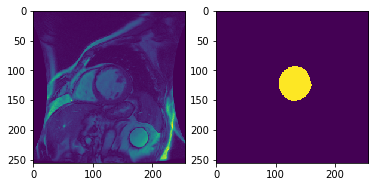

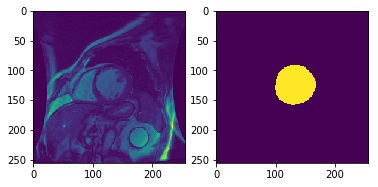

(None, None)

In [634]:
du.visualize_sidebyside(dicom_arr, imask), du.visualize_sidebyside(dicom_arr, omask)

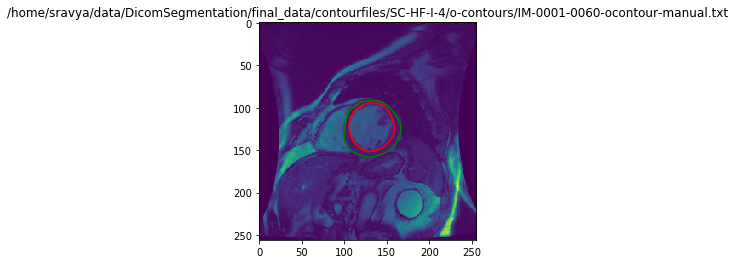

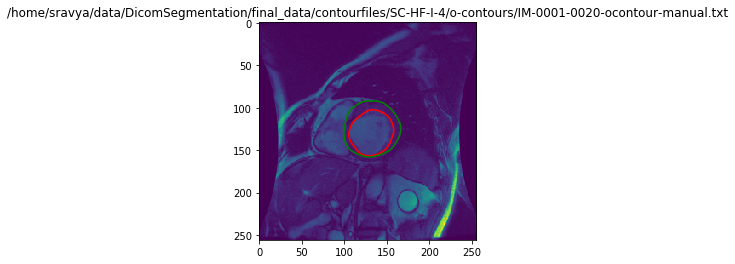

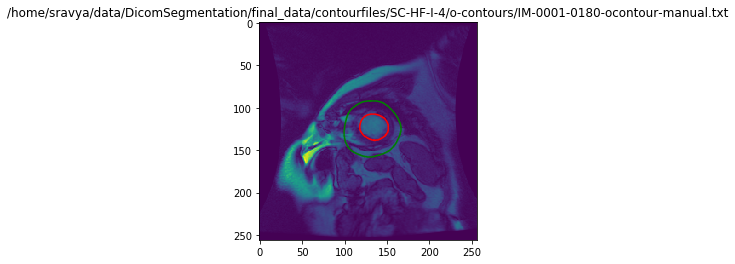

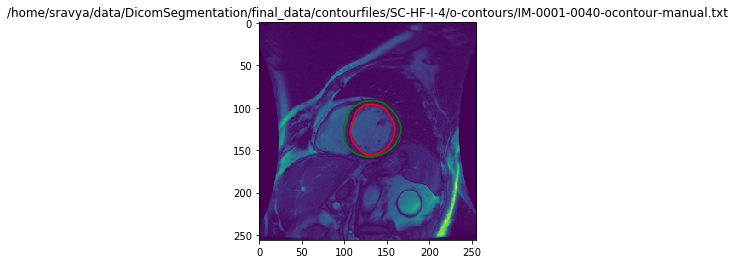

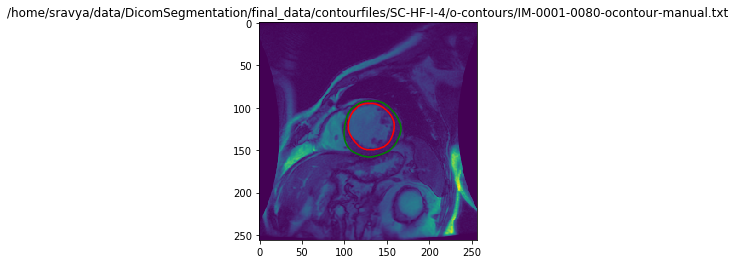

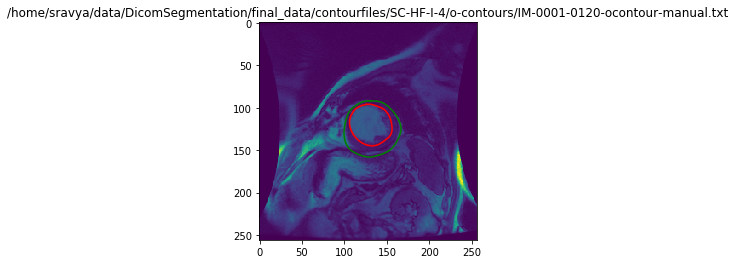

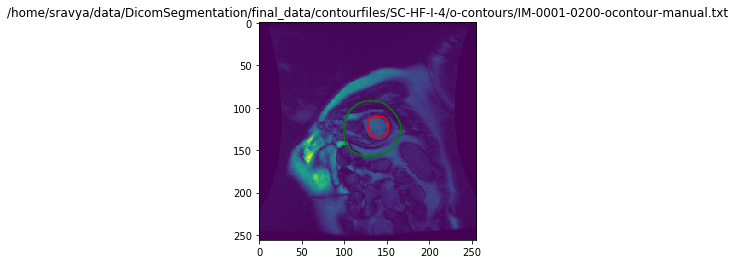

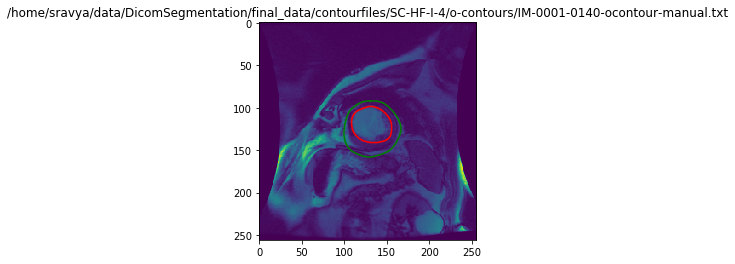

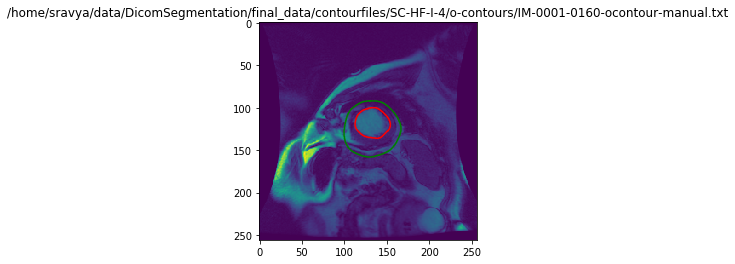

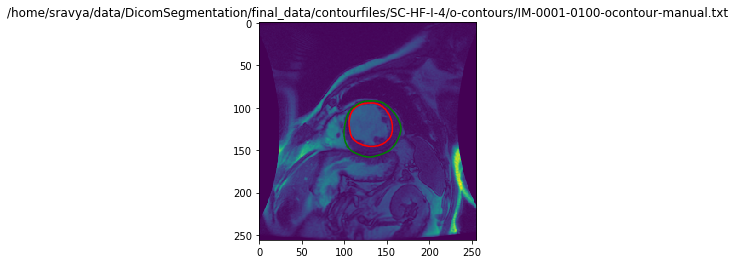

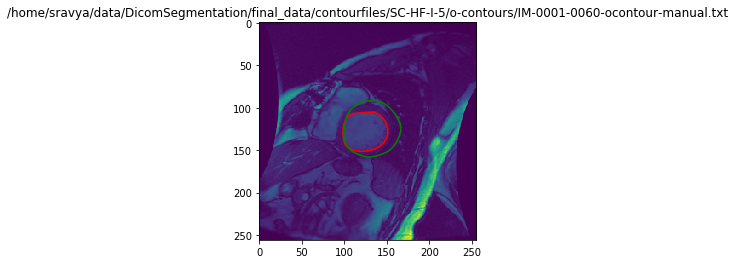

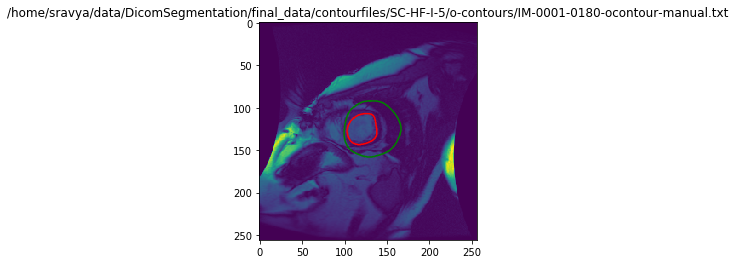

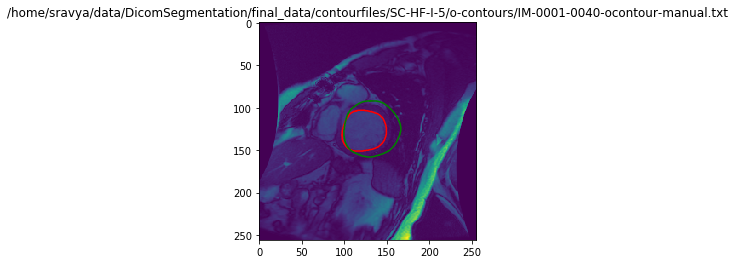

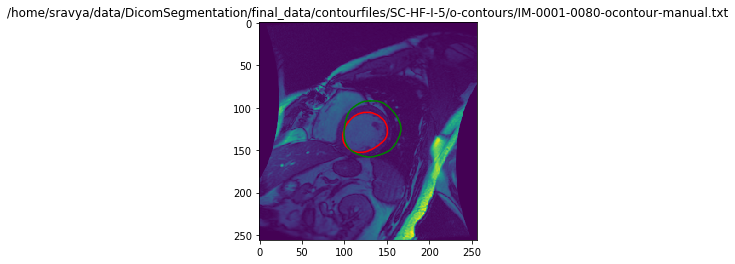

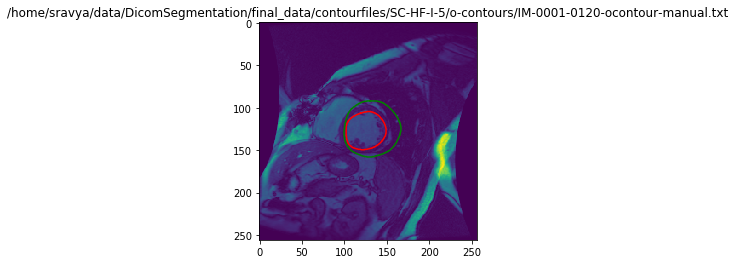

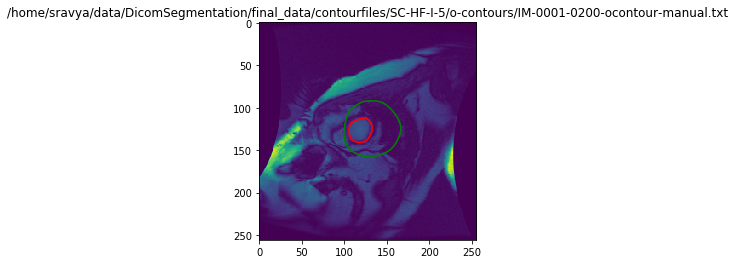

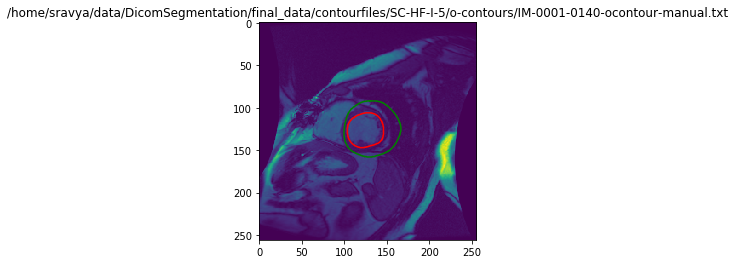

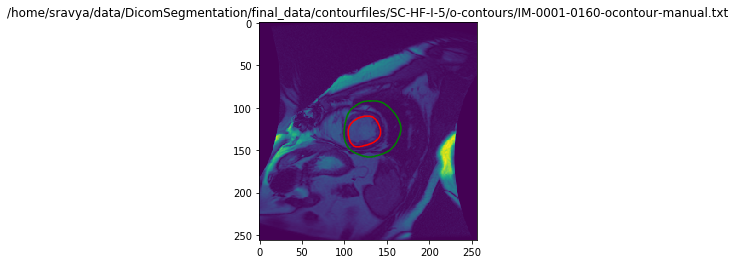

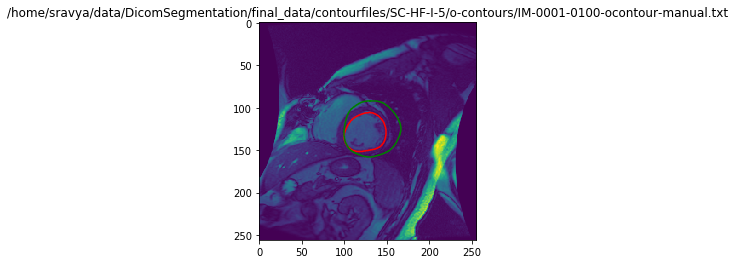

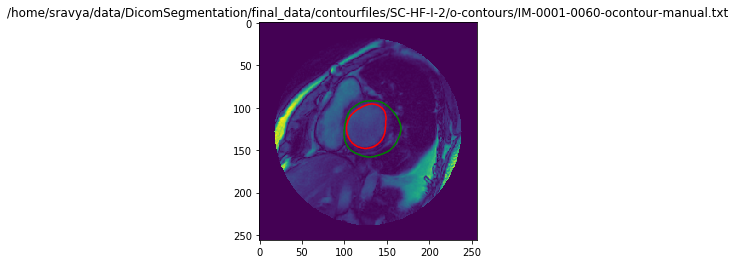

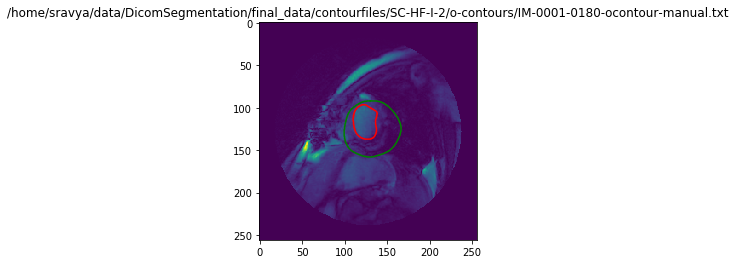

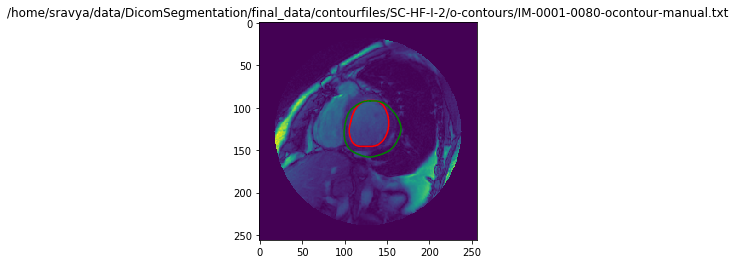

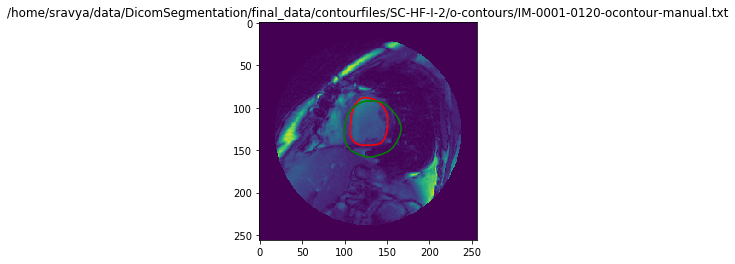

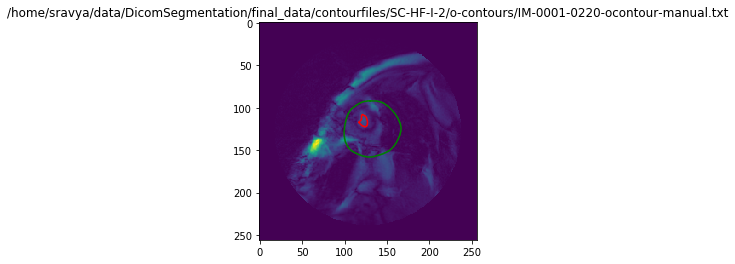

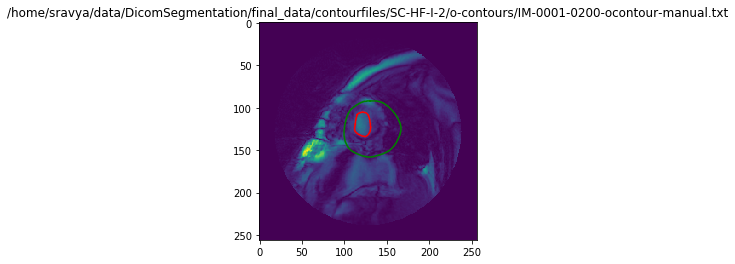

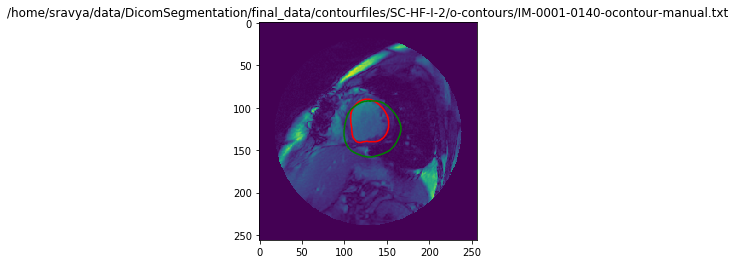

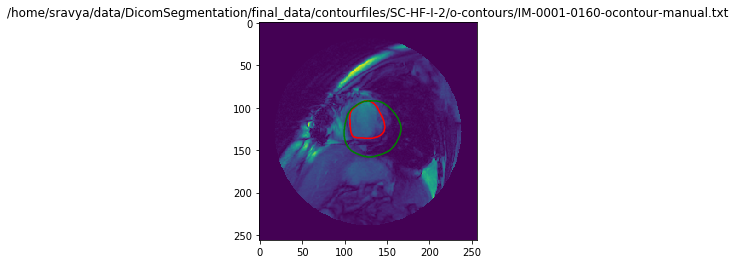

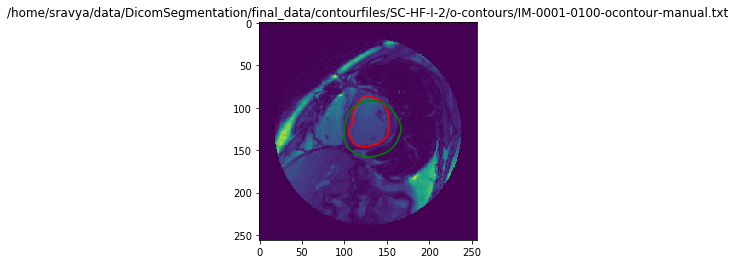

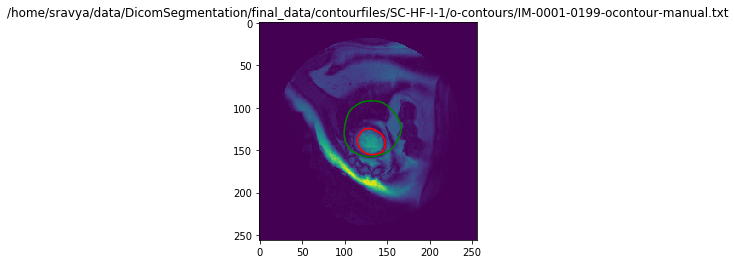

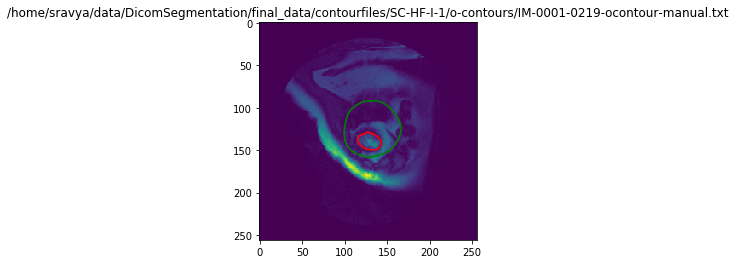

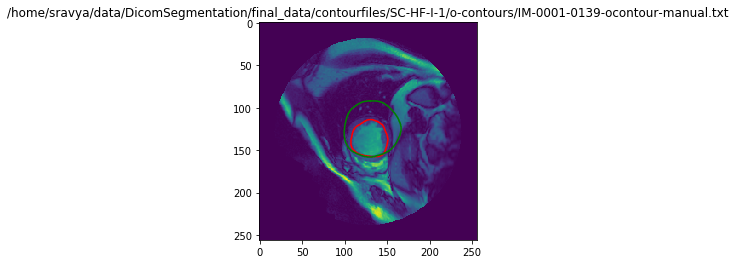

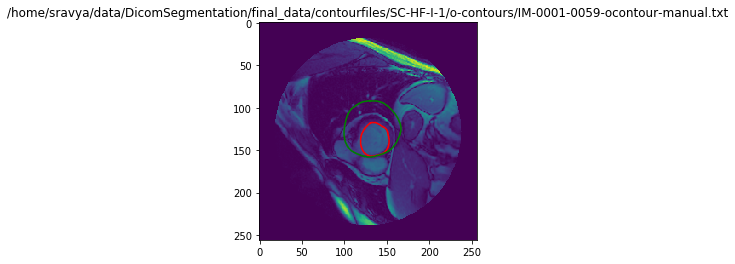

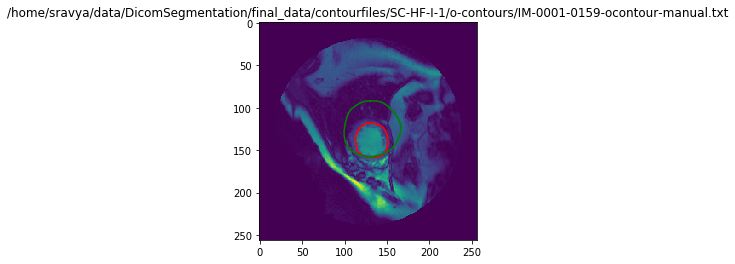

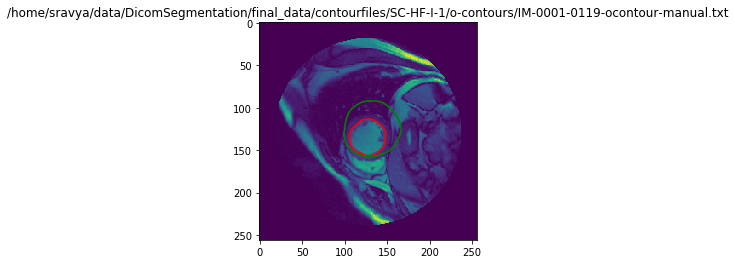

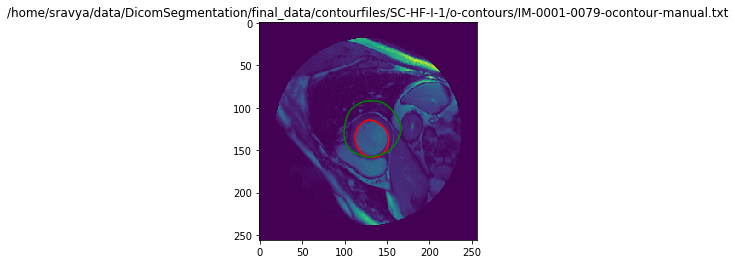

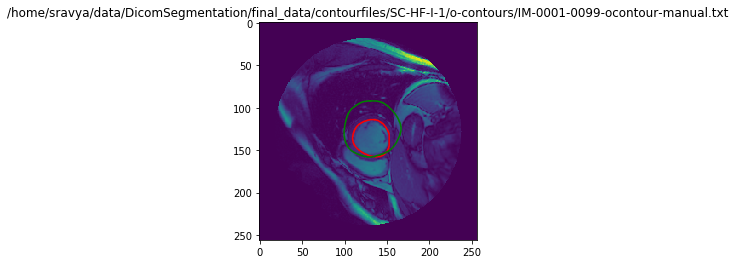

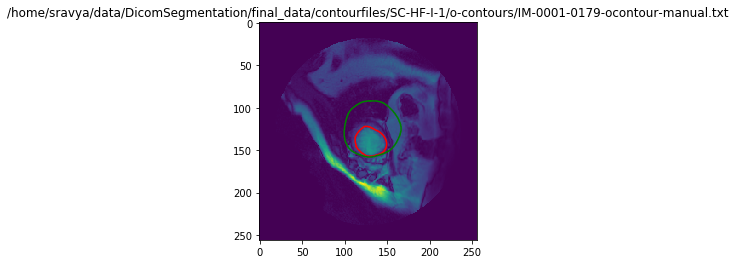

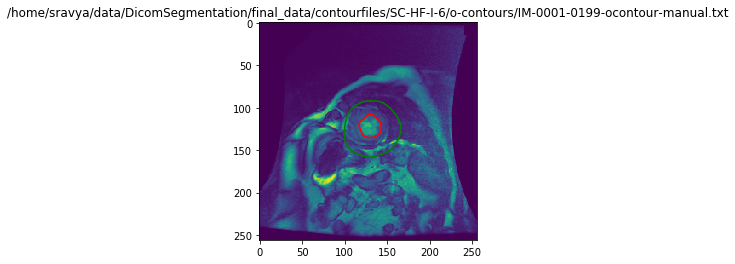

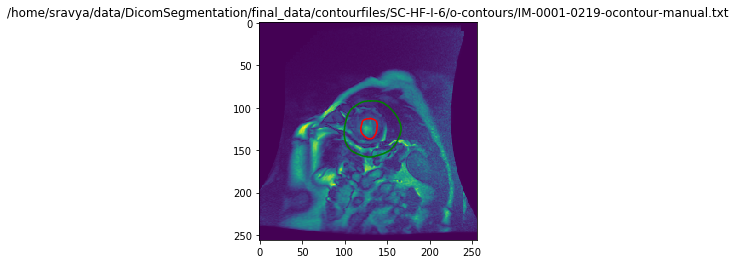

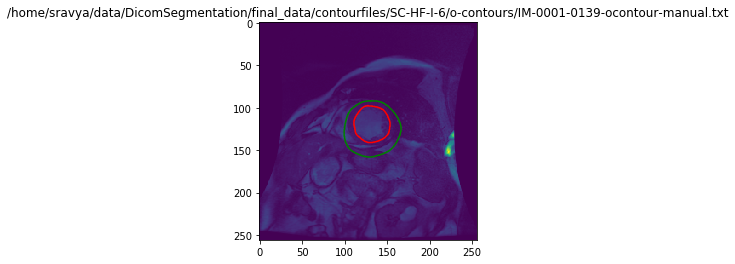

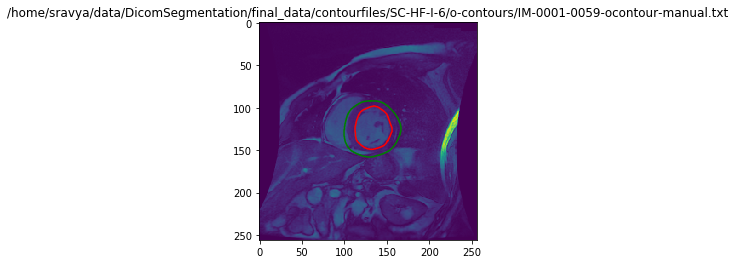

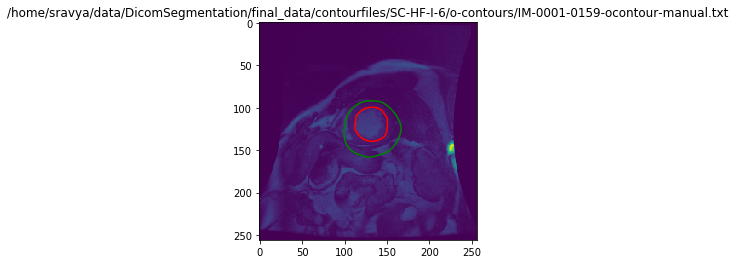

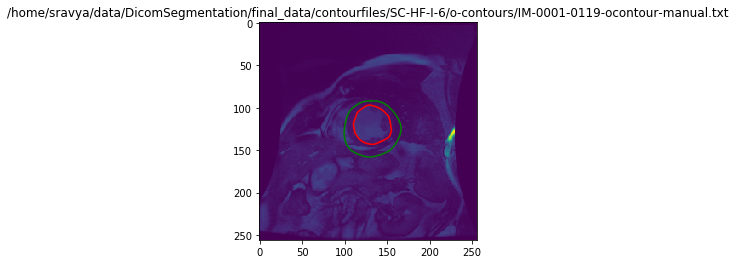

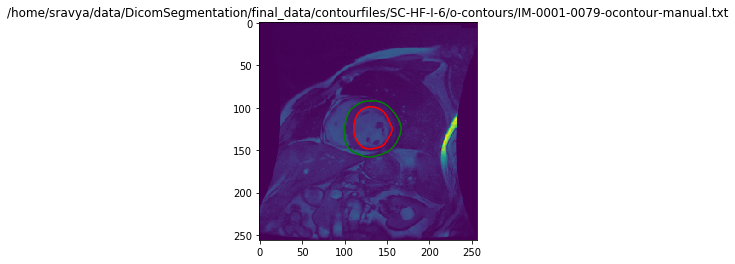

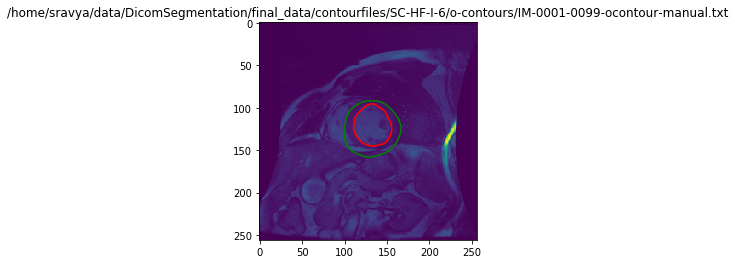

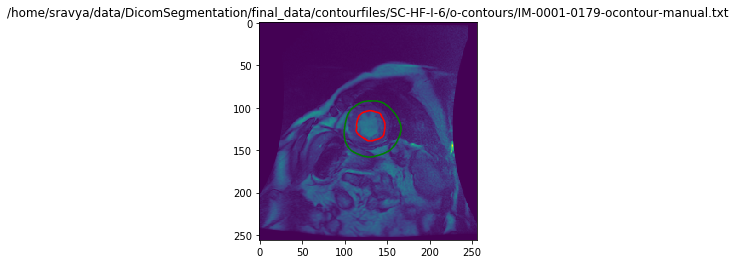

In [635]:
#Visualize overlayes for a few random icontour files for a visual sanity check
for file in ocfiles:
    dicom_arr, imask, ipolygon, omask, oplygon = du.get_dicom_and_mask(file)
    du.visualize_overlay(file, dicom_arr, [ipolygon, opolygon])

In [636]:
len(ocfiles)

46

# Explore sizes of the data

In [637]:
dicom_sizes = []
for file in ocfiles:
    dicom_arr, _,_,_,_ = du.get_dicom_and_mask(file)
    dicom_sizes.append(dicom_arr.shape)

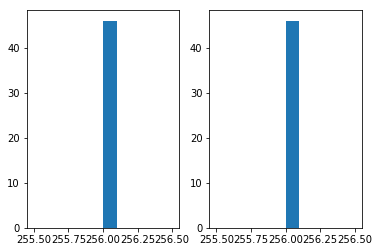

In [638]:
x = [size[0] for size in dicom_sizes]
y = [size[1] for size in dicom_sizes]
f, axarr = plt.subplots(1, 2)
axarr[0].hist(x)
axarr[1].hist(y)
plt.show()

In [639]:
#So all the dicoms are of shape (256,256)

# Use Data Generator

In [640]:
gen = du.data_generator(8)
try:
    while(1):
        dicoms,imasks,omasks = next(gen)
        print(dicoms.shape, imasks.shape, omasks.shape)
except StopIteration:
    pass
gen.close()

Starting data generator
(2048, 256) (2048, 256) (2048, 256)
(2048, 256) (2048, 256) (2048, 256)
(2048, 256) (2048, 256) (2048, 256)
(2048, 256) (2048, 256) (2048, 256)
(2048, 256) (2048, 256) (2048, 256)


# Phase 2 task 2

## Analyze intensities

In [649]:
#Utilities to mask everything else except region of interest
import numpy.ma as ma

def get_bb(mask):
    xmin =256
    xmax =0
    ymin=256
    ymax =0    
    for row in range(len(mask)):
        if any(mask[row]):
            xmin = row
            break
    for row in reversed(range(len(mask))):
        if any(mask[row]):
            xmax = row
            break
    for column in range(len(mask[0])):
        if any(mask[:,column]):
            ymin = column
            break
    for column in reversed(range(len(mask[0]))):
        if any(mask[:,column]):
            ymax = column
            break
    return xmin,xmax,ymin,ymax

def getThreshold(freq):
    return 160

def analyze(ocfile):
    dicom_arr, imask, ipolygon, omask, opolygon = du.get_dicom_and_mask(ocfile)
    
    xmin,xmax,ymin,ymax = get_bb(omask)
    omask = omask[xmin:xmax+1,ymin:ymax+1]
    imask = imask[xmin:xmax+1,ymin:ymax+1]
    blood_muscle_dicom = dicom_arr[xmin:xmax+1,ymin:ymax+1]
    
    #blood_muscle = mask_bg(blood_muscle_dicom,)
    blood_muscle = ma.masked_array(blood_muscle_dicom, ~omask)
    blood_muscle = ma.filled(blood_muscle, fill_value=0)
    
    blood = ma.masked_array(blood_muscle, ~imask)
    blood = ma.filled(blood, fill_value=0)
    
    muscle = ma.masked_array(blood_muscle, imask)
    muscle = ma.filled(muscle, fill_value=0)
    plt.clf()
    f, axarr = plt.subplots(2, 3)
    axarr[0,0].imshow(blood)
    axarr[0,0].set_title("Blood")
    
    axarr[0,1].imshow(muscle)
    axarr[0,1].set_title("Muscle")
    
    blood_freq = blood.ravel()[blood.ravel()>0]
    muscle_freq = muscle.ravel()[muscle.ravel()>0]
    blood_muscle_freq = blood_muscle.ravel()[blood_muscle.ravel()>0]
    
    axarr[1,0].hist(blood_freq, alpha=0.7), axarr[1,0].hist(muscle_freq, alpha=0.7)
    axarr[1,0].set_title("Blood, Muscle")
    
    axarr[1,1].hist(blood_muscle_freq, alpha=0.7)
    axarr[1,1].set_title("Blood+Muscle")
    
    axarr[1,2].hist(abs(blood.ravel()-muscle.ravel()), alpha=0.7)
    axarr[1,2].set_title("Blood-Muscle")
    
    threshold = getThreshold(blood_muscle_freq)
    axarr[0,2].imshow(upper_bound(blood_muscle,threshold))
    axarr[0,2].set_title("Thresholded at {}".format(threshold))
    plt.tight_layout()
    plt.show()
    
def upper_bound(dicom, threshold):
    bounded = np.empty((dicom.shape))
    for row in range(len(dicom)):
        for column in range(len(dicom[0])):
            if dicom[row,column]>threshold:
                bounded[row,column] = 0
            else:
                bounded[row,column] = dicom[row,column]
    return bounded           

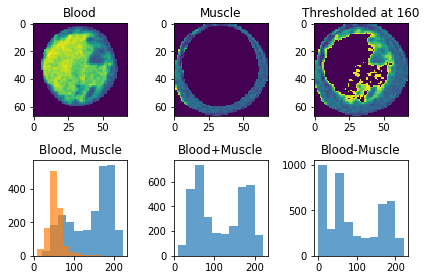

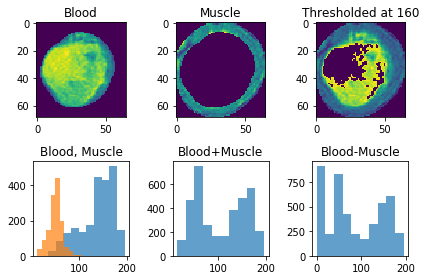

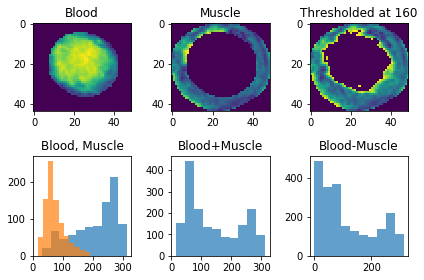

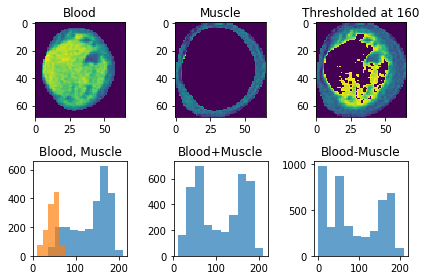

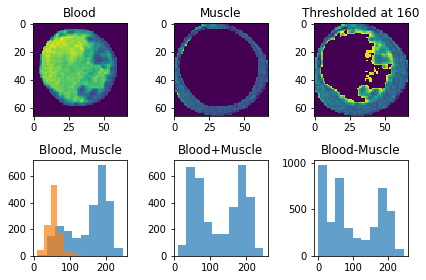

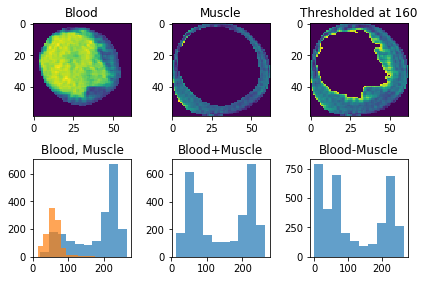

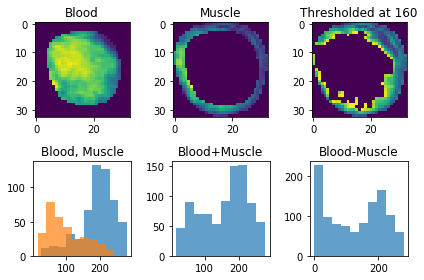

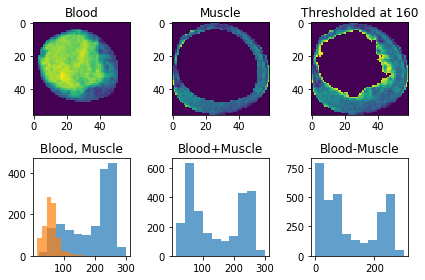

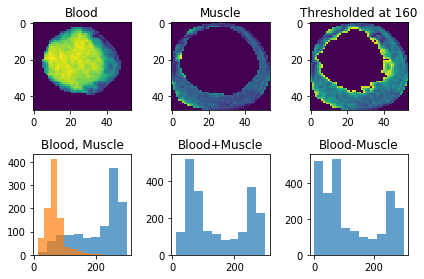

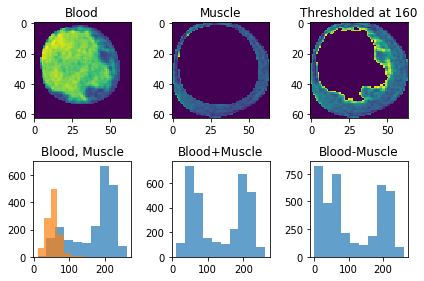

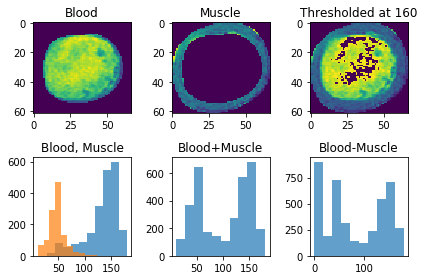

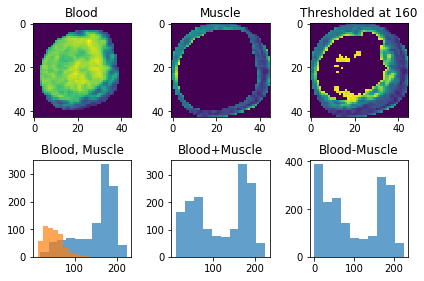

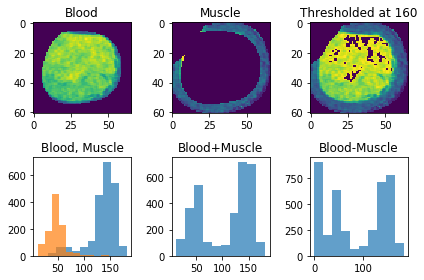

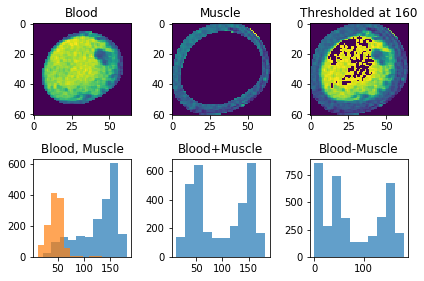

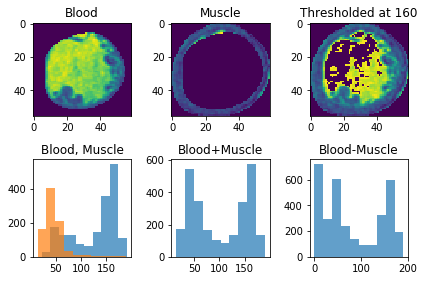

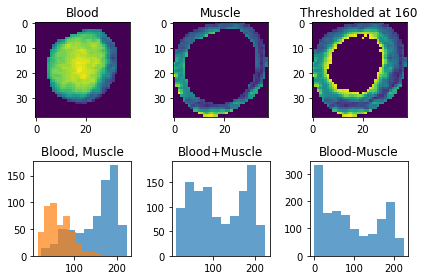

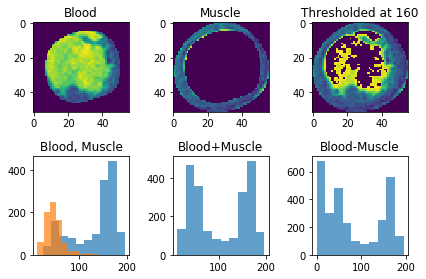

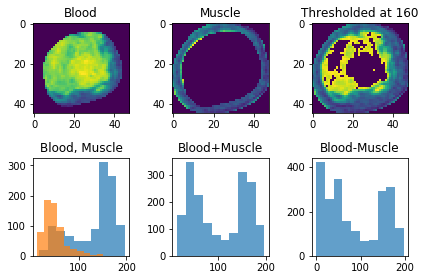

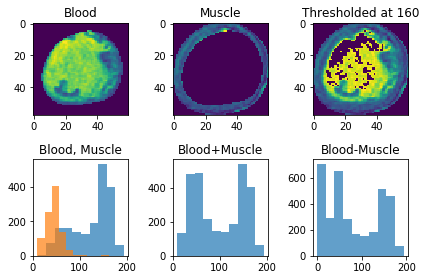

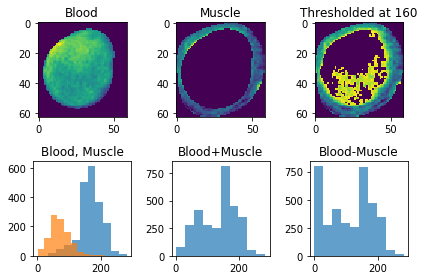

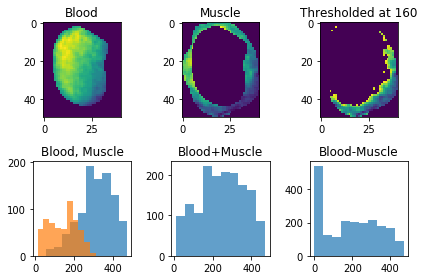

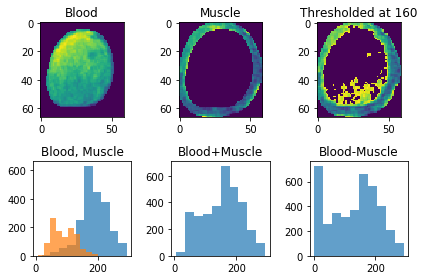

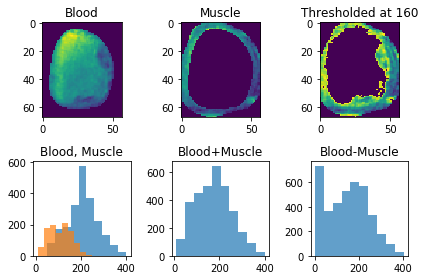

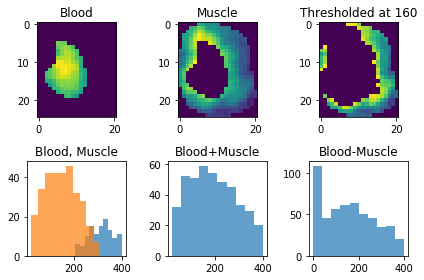

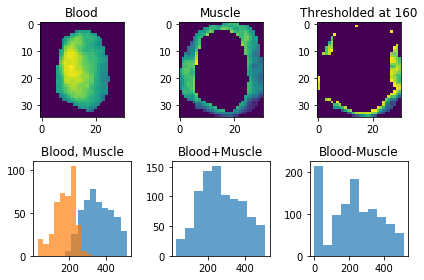

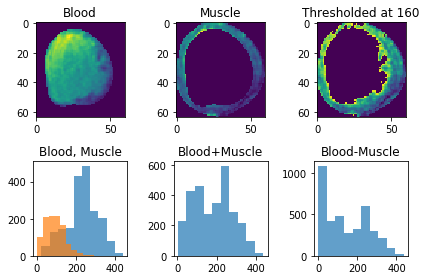

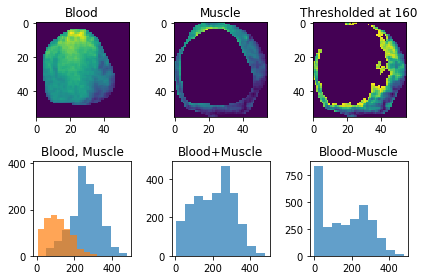

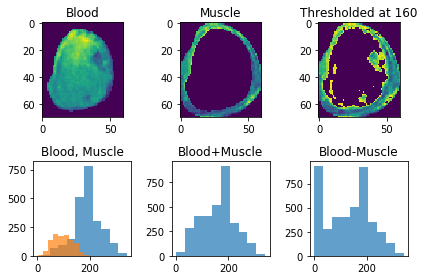

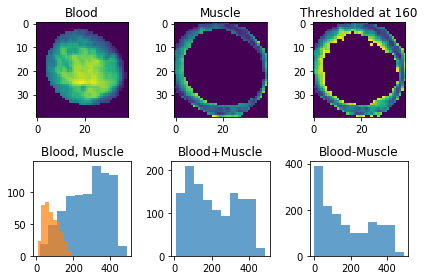

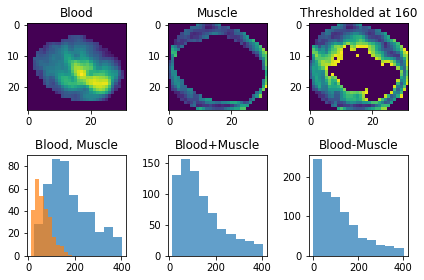

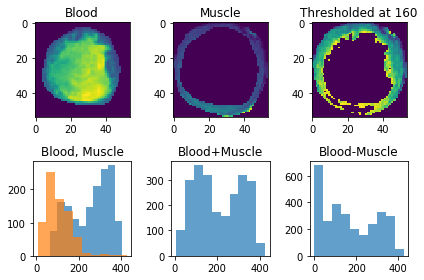

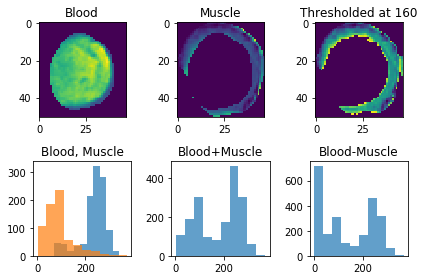

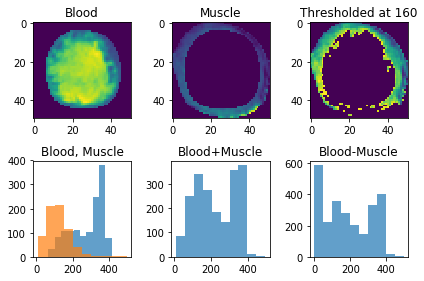

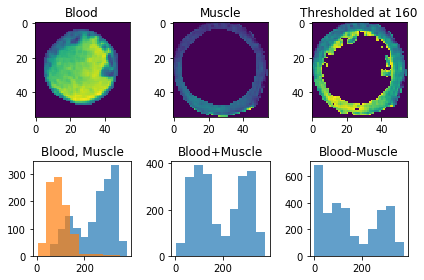

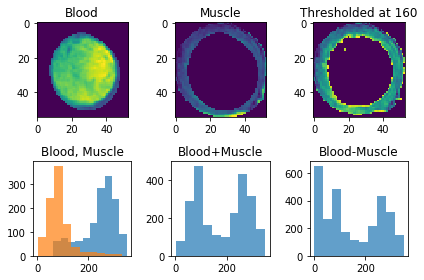

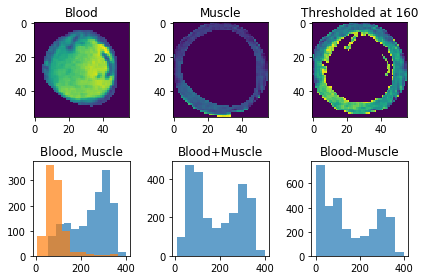

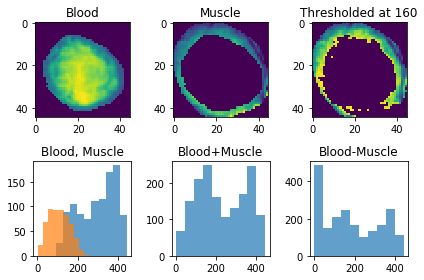

In [650]:
for ocfile in ocfiles:
    analyze(ocfile)